In [1]:
%matplotlib inline
import segpy
from segpy.reader import create_reader
from segpy.writer import write_segy

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import  Image

import os
import shutil

from collections import defaultdict, Counter
import joblib
import pickle

from scipy.stats import mode
from scipy.stats import entropy
from scipy import ndimage

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

%run bp_smc_example.ipynb

In [2]:
len(os.listdir('small_dataset'))

120

In [ ]:
# split up stack and gather files into separate directories
for filename in os.listdir('small_dataset'):
    src = 'small_dataset/' + filename
    if 'gather' in filename:
        dst = 'gather/' + filename
        shutil.copy(src, dst)
    if 'stack' in filename:
        dst = 'stack/' + filename
        shutil.copy(src, dst)
        
# make a dictionary of arrays for every realization in stack
stack_dict = {}
for filename in os.listdir('stack')[1:-1]:
    arr = np.zeros((1058, 400))

    with open(f'stack/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[trace_index, i] = data[i]
    stack_dict[filename] = arr
    
# make a dictionary of arrays for every realization in stack
gather_dict = {}
for filename in os.listdir('gather')[1:-1]:
    arr = np.zeros((1058, 39, 400))
    with open(f'gather/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        count = 0
        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[int(trace_index / 39), trace_index % 39, i] = data[i]
    gather_dict[filename] = arr
    

In [100]:
# make a dictionary of arrays for every realization in big dataset
large_dict = {}
for filename in os.listdir('large_dataset_only_realizations')[1:-1]:
    arr = np.zeros((1058, 400))

    with open(f'large_dataset_only_realizations/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[trace_index, i] = data[i]
    large_dict[filename] = arr

In [ ]:
# print_segy_info('stack/img_12.stack.segy')

In [3]:
# load the two dictionaries into the directory to use later
# joblib.dump(stack_dict, 'stack_dict')
# stack_dict = joblib.load(open('stack_dict', 'rb'))

# joblib.dump(gather_dict, 'gather_dict')
gather_dict = joblib.load(open('gather_dict', 'rb'))

# joblib.dump(large_dict, 'large_dict')
# large_dict = joblib.load(open('large_dict', 'rb'))

In [ ]:
# functions for getting the mode and kl_divergence
def mode_func(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], 

# this function is not necessary
def kl_divergence(p, q):
    kl1 = np.sum(np.where(p != 0, p * np.log(p / q), 0))
    kl2 = np.sum(np.where(q != 0, q * np.log(q / p), 0))
    return (kl1 + kl2) / 2

In [102]:
# function computes the uncertainty image of all the stack segy files
cnt = Counter()

def uncertainty_image(stack_dict):
#     arrays = []
    # kl_arr is the array that will compute uncertainty image of all realizations  
    kl_arr = np.zeros((1058, 400))
    
    # big_arr makes a 3-d numpy array that will store pixels of each realization
    big_arr = np.zeros((len(stack_dict), 1058, 400))
    
    index = 0
    for key in stack_dict.keys():
        arr = stack_dict[key]
        big_arr[index, :, :] = arr
        index += 1  
    
    # give every pixel value a kl_divergence value based on distributions
    
    big_arr_min = big_arr.min()
    big_arr_max = big_arr.max()
    for i in range(1058):
        for j in range(400):

            # create bins corresponding to the range of each length 58 arr
            arr = big_arr[:, i, j]
            bins = np.linspace(big_arr_min, big_arr_max, num=11)
            binned_arr = np.digitize(arr, bins, right=True)

            # count up the frequency of the bins that occupied and find the most frequently occurring value
            cnt = np.zeros(10)
            for val in binned_arr:
                cnt[val-1] += 1

            freq_arr = cnt
            max_val = max(freq_arr)

            # one hot encode a length 10 vector to give a 1 to the bin with the most number of values in it
            onehot_arr = [1e-9 if x != max_val else 1.0 - (1e-9 * (len(freq_arr) - 1)) for x in freq_arr]

            # compute kl between one hot vector and freq_arr which is a likelihood probability vector of the bins
            kl_score = entropy(freq_arr, onehot_arr)

            # store the kl_score as a matrix filled with that value
            kl_arr[i, j] = kl_score

    score_arr = kl_arr

    score_arr = score_arr.transpose()
    min_arr = score_arr.min()
    max_arr = score_arr.max()
    score_arr = (score_arr - min_arr) / (max_arr - min_arr)
    score_arr = score_arr * 255
    
#     score_arr = uniform_filter(score_arr, size=10, mode='nearest')

    im = Image.fromarray(score_arr)
    im = im.convert('RGB')

    return kl_arr, im

In [106]:
small_kl_arr, small_image = uncertainty_image(stack_dict)
large_kl_arr, large_image = uncertainty_image(large_dict)

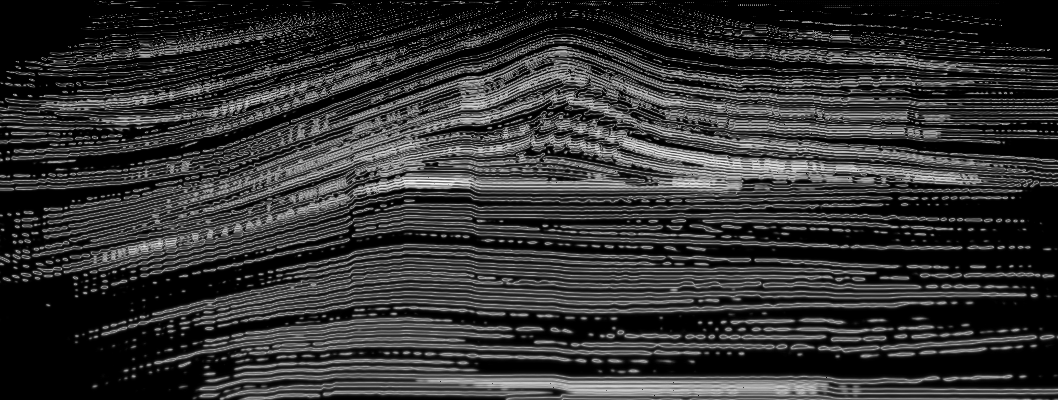

In [115]:
# small_image
large_image

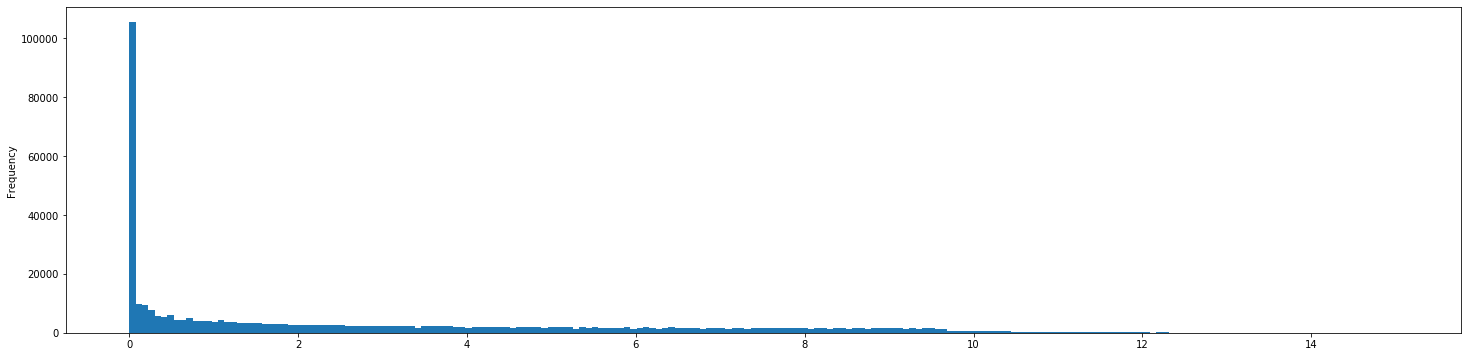

In [118]:
pd.Series(large_kl_arr.flatten()).plot(kind='hist', figsize=(25, 6), bins=200);

In [92]:
def crop_and_zoom(im, lo, hi, basewidth):
    cropped = im.crop((lo[0], lo[1], hi[0], hi[1]))
    wpercent = (basewidth/float(cropped.size[0]))
    hsize = int((float(cropped.size[1])*float(wpercent)))
    return cropped.resize((basewidth,hsize), Image.ANTIALIAS).convert('RGB')

def crop_zoom_concat(arr1, arr2, lo, hi, basewidth):
    cropped1 = arr1[lo[1]:hi[1], lo[0]:hi[0]]
    cropped2 = arr2[lo[1]:hi[1], lo[0]:hi[0]]
    # rescale the two cropped images
    min1 = cropped1.min()
    max1 = cropped1.max()
    cropped1 = (cropped1 - min1) / (max1 - min1)
    cropped1 = cropped1 * 255
    min2 = cropped2.min()
    max2 = cropped2.max()
    cropped2 = (cropped2 - min2) / (max2 - min2)
    cropped2 = cropped2 * 255
    stacked = np.hstack((cropped1, cropped2))
    print(stacked.shape)
    img = Image.fromarray(stacked)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    return img.resize((basewidth,hsize), Image.ANTIALIAS).convert('RGB')

In [2]:
crop_and_zoom(image, (400, 200), (450, 220), 1000)
# crop_zoom_concat(kl_arr.transpose(), stack_dict['img_2.stack.segy'].transpose(), (400, 200), (450, 220), 1500)
# crop_zoom_concat(kl_arr.transpose(), stack_dict['img_4.stack.segy'].transpose(), (500, 370), (550, 390), 1500)

NameError: name 'crop_and_zoom' is not defined

<h2 style="color:blue;"> Process gathers and find standard deviation summations for each realization </h2>

In [4]:
print(gather_dict['img_1.gather.segy'].shape)
from skimage import feature
# import itertools
# import random
from sklearn.preprocessing import RobustScaler

(1058, 39, 400)


<h2 style="color:blue;"> Process gathers using canny filter and determine the quality determined by horizontal lines </h2>

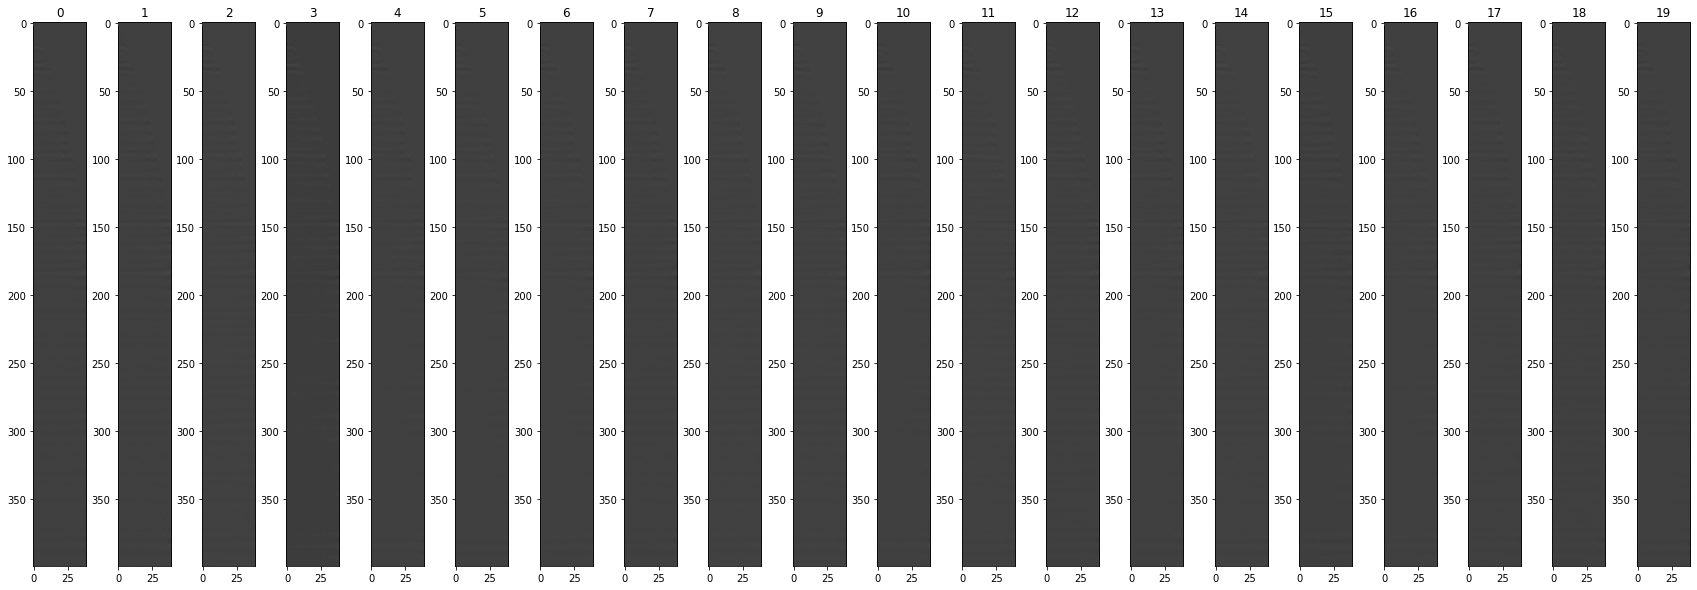

In [11]:
# this is to pick out some random gathers to see which ones to test on 
nrows = 1
ncols = 20

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 10))

# horizontal gradient (detects vertical edges)
for c in range(ncols):
    name = list(gather_dict.keys())[c]
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict[name][500, :, :]
    sub_arr = sub_arr.transpose()
    sub_shape = sub_arr.shape
    sub_arr = RobustScaler().fit_transform(sub_arr).reshape(sub_shape)
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')

    title = str(c)
    axarr[c].set_title(title.strip())

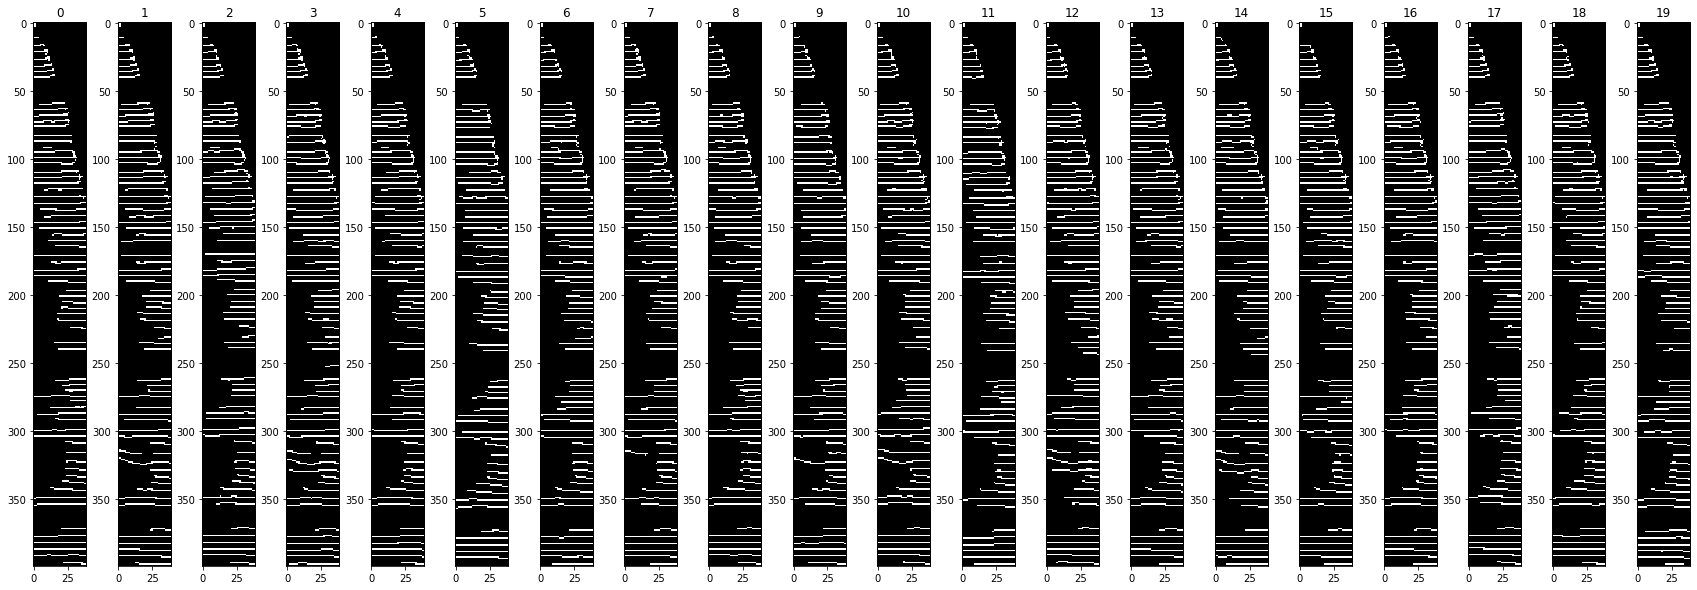

In [15]:
# for image 1, get the arrays of each gather after passing through canny filter
# this is to pick out some random gathers to see which ones to test on 
nrows = 1
ncols = 20

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 10))
dup_vals = {}
# horizontal gradient (detects vertical edges)
for c in range(ncols):
    name = list(gather_dict.keys())[c]
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict[name][500, :, :]
    sub_arr = sub_arr.transpose()
    sub_shape = sub_arr.shape
    sub_arr = RobustScaler().fit_transform(sub_arr).reshape(sub_shape)
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    edges = feature.canny(sub_arr, sigma=3)
    dup_vals[c] = edges
    axarr[c].imshow(edges, cmap = 'gray')

    title = str(c)
    axarr[c].set_title(title.strip())
    


In [17]:
# joblib.dump(dup_vals, 'dup_vals')
dup_vals = joblib.load(open('dup_vals', 'rb'))

In [19]:
# length 1058 dictionary, each corresponding to a list of 400 values that can be either 0 or 1 depending on the mode of the row

def canny_func(dup_vals):
    mode_dict = defaultdict(list)
    mean_dict = defaultdict(list)
    diff_dict = defaultdict(int)

    for c in range(20):
        dup_vals[c] = dup_vals[c].astype(int)
        for row in dup_vals[c]:
            mode_dict[c].append(mode(row)[0][0])
            mean_dict[c].append(np.mean(row))
            counter_dict = Counter(mode_dict[c])
            cnt_0, cnt_1 = counter_dict[0], counter_dict[1]
            diff_dict[c] = abs(cnt_0 - cnt_1)

    return mode_dict, mean_dict

mode_dict, mean_dict = canny_func(dup_vals)

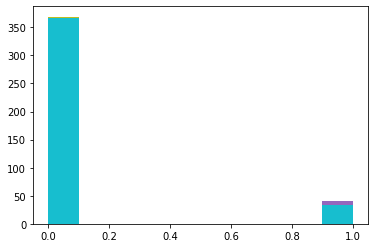

In [20]:
for key in mode_dict:
    plt.hist(mode_dict[key]);
# for key in mean_dict:
#     plt.hist(mean_dict[key], alpha=0.2);

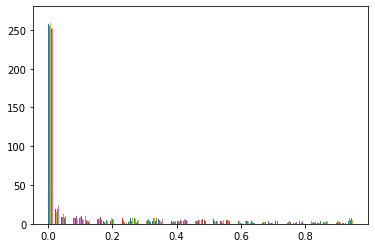

In [22]:
plt.hist(mean_dict.values(), bins=50);
# len(diff_dict.values())

In [29]:
# this code was necessary to round pre-scaled pixels to the nearest 0.0/1.0 value
round_dict = defaultdict(int)
for c in range(ncols):
    # Pull out all offset pairs for a given x
    gather = dup_vals[c]
    rounded = []
    for row in gather:
        rounded.append([0.0 if x <= 0.5 else 1.0 for x in row])
    round_dict[c] = np.array(rounded)

# this dictionary finds the mode (0/1) per row for a gather 
mode_dict = defaultdict(list)
for c in range(ncols):
    gather = round_dict[c]
    for row in gather:
        mode_val, _ = mode(row)
        mode_dict[c].append(mode_val[0])

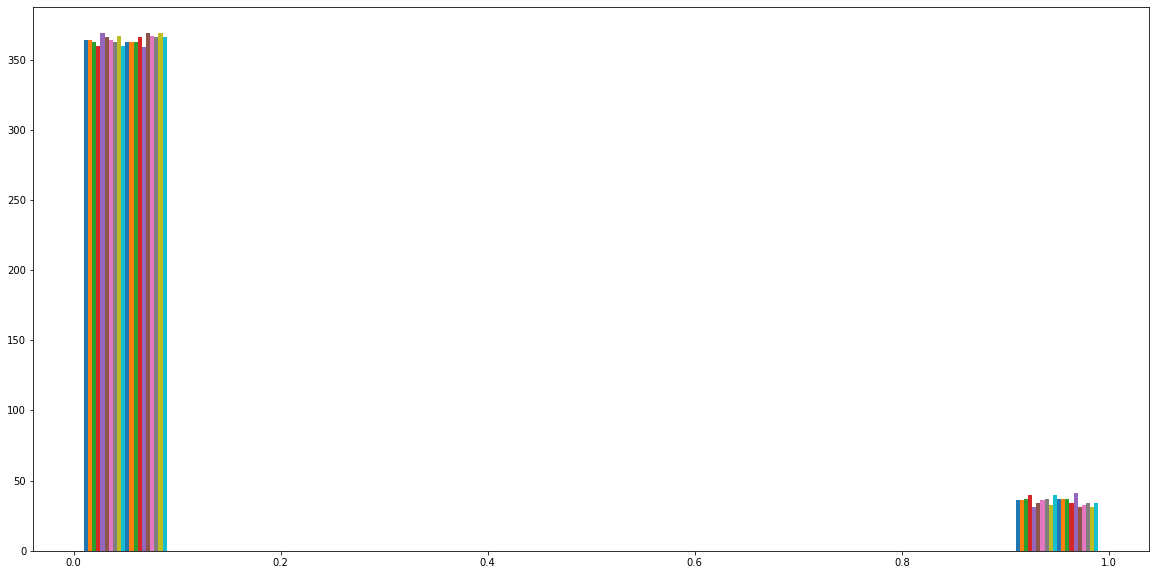

In [21]:
# this plots the histogram distribution of all 1058 gathers for a given file
values = mode_dict.values()
plt.figure(figsize=(20, 10))
plt.hist(values);

In [ ]:
# computes horizontal derivative (vertical edges)
sub_arr_x = ndimage.sobel(sub_arr, 0)
axarr[c].imshow(sub_arr_x, cmap = 'gray')

# computes vertical derivative (horizontal edges)
sub_arr_y = ndimage.sobel(sub_arr, 1)
axarr[c+1].imshow(sub_arr_y, cmap = 'gray')

# computes vertical derivative (horizontal edges)
sub_arr_lap = ndimage.laplace(sub_arr)
axarr[c+2].imshow(sub_arr_lap, cmap = 'gray') 

In [6]:
def gather_std(gather_dict, ncols=1058):
    std_dict = defaultdict(list)

    std_sums = defaultdict(list)
    for key in gather_dict.keys():
        arr = gather_dict[key]
        std_sum = 0
        
        # for each of the 1058 ncol GATHERs
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = arr[c, :, :]
            sub_arr = sub_arr.transpose()
            min_arr = sub_arr.min()
            max_arr = sub_arr.max()
            sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
            sub_arr = sub_arr * 255
            
            std_val = np.std(sub_arr, axis=0).sum()
            std_dict[key].append(std_val)
        
    return std_dict

std_dict = gather_std(gather_dict)

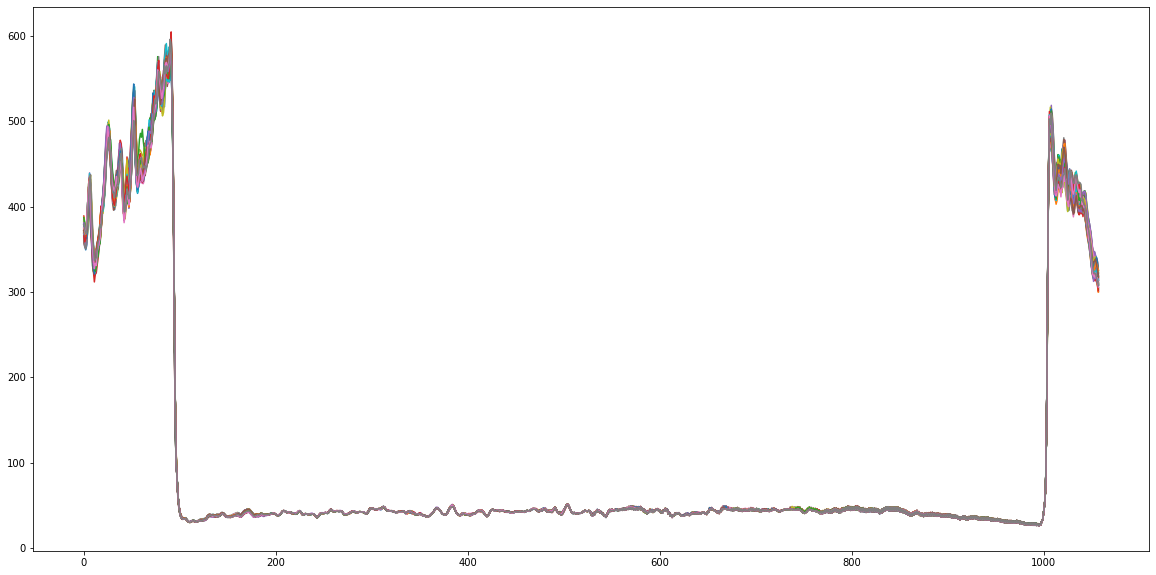

In [10]:
# this plots the std deviation distribution of the rows of all 1058 gathers
plt.figure(figsize=(20, 10))
for key in std_dict:
    plt.plot(std_dict[key])

In [13]:
min_std = std_dict['img_1.gather.segy'].index(min(std_dict['img_1.gather.segy']))
max_std = std_dict['img_1.gather.segy'].index(max(std_dict['img_1.gather.segy']))
std_list = [min_std, max_std]

# sort by lowest to highest std among gathers for one image
sort_std = sorted(std_dict['img_1.gather.segy'])
min5_std = sort_std[0:10]
max5_std = sort_std[-11:-1]

# get their indices
min_std_ind = [std_dict['img_1.gather.segy'].index(x) for x in min5_std]
max_std_ind = [std_dict['img_1.gather.segy'].index(x) for x in max5_std]

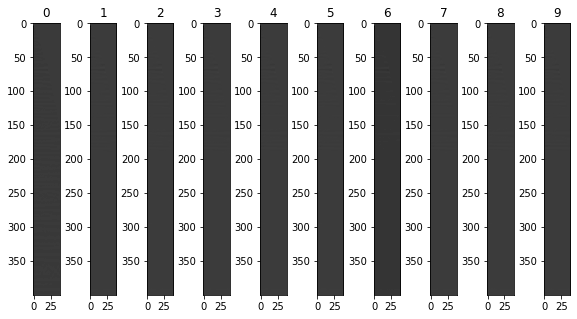

In [17]:
# top 10 gathers with lowest total std (image 1)
nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 5))

c = 0
for index in min_std_ind:
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict['img_1.gather.segy'][index, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())
    c += 1

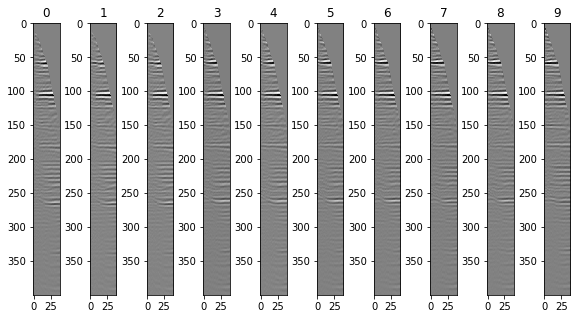

In [18]:
# top 10 gathers with highest total std (image 1)
nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 5))

c = 0
for index in max_std_ind:
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict['img_1.gather.segy'][index, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())
    c += 1